In [1]:
import argparse
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pygad
# import wandb
import pandas as pd
import tensorflow.keras.backend as K
from tensorflow.python.client import device_lib
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# print(device_lib.list_local_devices())

import matplotlib.pyplot as plt
tf.random.set_seed(0)
np.random.seed(0)

2023-12-21 10:40:19.147942: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-21 10:40:19.935148: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-21 10:40:20.109877: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/macula/SMATousi/.conda/envs/mac-deep/lib/:/home/macula/SMATousi/.conda/envs/mac-deep/li

In [2]:
def generate_dataset_refined(n_samples=100000, n_outliers=100, dimensions=20):
    # Generate inliers uniformly within a range
    inliers = np.random.uniform(-1, 1, size=(n_samples - n_outliers, dimensions))

    # Prepare to generate outliers
    outlier_samples = []
    outlier_indices = []
    outlier_dims = []

    # Define different clusters of outliers
    cluster_definitions = [
        (0, 7),    # First 7 dimensions
        (5, 10),   # 5 dimensions in the middle
        (3, 8),    # Another set of 5 dimensions, overlapping with the first
        (1, 6),    # 5 dimensions starting from second
        (6, 10),   # Last 4 dimensions
        (0, 4),    # First 4 dimensions
        (2, 7),    # 5 dimensions starting from third
        (4, 9),    # 5 dimensions starting near the middle
        (3, 6),    # 3 dimensions in the middle
        (7, 10)    # Last 3 dimensions
    ]

    # Adjust if the number of dimensions is different
    if dimensions != 10:
        scaling_factor = dimensions // 10
        cluster_definitions = [(start * scaling_factor, min(end * scaling_factor, dimensions)) for start, end in cluster_definitions]

    # Generate outliers for each cluster
    for start, end in cluster_definitions:
        for _ in range(n_outliers // len(cluster_definitions)):
            # Normal values for non-deviating dimensions
            normal_dims = list(set(range(dimensions)) - set(range(start, end)))
            outlier = np.random.uniform(-1, 1, dimensions)
            # More extreme values for the deviating dimensions
            outlier[start:end] = np.random.uniform(1, 10, end - start)
            
            outlier_samples.append(outlier)
            outlier_indices.append(len(inliers) + len(outlier_samples) - 1)
            outlier_dims.append((start, end))

    # Combine inliers and outliers
    dataset = np.vstack([inliers, np.array(outlier_samples)])

    return dataset, outlier_indices, outlier_dims

In [3]:

def train_VAE(data,
              latent_dim = 2,
              hidden_layer_n = [20,18,16],
              num_dims = 10,
              kl_loss_factor = 0.01,
              epochs = 100,
              batch_size = 128
              ):


    """
    Training the VAE on the data
    """

    class Sampling(layers.Layer):
        """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

        def call(self, inputs):
            z_mean, z_log_var = inputs
            batch = tf.shape(z_mean)[0]
            dim = tf.shape(z_mean)[1]
            epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
            return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    latent_dim = latent_dim

    encoder_inputs = keras.Input(shape=(num_dims,))
    x = layers.Dense(num_dims, activation="sigmoid")(encoder_inputs)
    x = layers.Dense(hidden_layer_n[0], activation="sigmoid")(x)
    x = layers.Dense(hidden_layer_n[1], activation="sigmoid")(x)
    x = layers.Dense(hidden_layer_n[2], activation="sigmoid")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(hidden_layer_n[2], activation="sigmoid")(latent_inputs)
    x = layers.Dense(hidden_layer_n[1], activation="sigmoid")(x)
    x = layers.Dense(hidden_layer_n[0], activation="sigmoid")(x)
    decoder_outputs = layers.Dense(num_dims, activation="linear")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

    class VAE(keras.Model):
        def __init__(self, encoder, decoder, **kwargs):
            super().__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder
            self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
            self.reconstruction_loss_tracker = keras.metrics.Mean(
                name="reconstruction_loss"
            )
            self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

        @property
        def metrics(self):
            return [
                self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker,
            ]

        def train_step(self, data):
            with tf.GradientTape() as tape:
                z_mean, z_log_var, z = self.encoder(data)
                reconstruction = self.decoder(z)
                reconstruction_loss = tf.keras.losses.MeanSquaredError()(data,reconstruction)
                kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
                total_loss = reconstruction_loss + kl_loss_factor * kl_loss
        
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_tracker.update_state(kl_loss)
            return {
                "loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),
            }
    
    creditdata = np.concatenate([data], axis=0)
    creditdata = np.expand_dims(creditdata, -1).astype("float32")

    vae = VAE(encoder, decoder)
    vae.compile(optimizer=tf.keras.optimizers.Adam())
    history = vae.fit(creditdata,epochs=epochs,batch_size=batch_size,verbose=0)

    return vae, history




def train_RAE(data,
              latent_dim = 2,
              hidden_layer_n = [20,18,16],
              num_dims = 10,
              z_loss_w = 0.01,
              REG_loss_w = 0.01,
              epochs = 100,
              batch_size = 128
              ):


    """
    Training the RAE on the data
    """


    encoder_inputs = keras.Input(shape=(num_dims,))
    x = layers.Dense(hidden_layer_n[0], activation="sigmoid")(encoder_inputs)
    x = layers.Dense(hidden_layer_n[1], activation="sigmoid")(x)
    x = layers.Dense(hidden_layer_n[2], activation="sigmoid")(x)
    encoder_output = layers.Dense(latent_dim, activation="sigmoid")(x)
    encoder = keras.Model(encoder_inputs, encoder_output, name="encoder")

    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(hidden_layer_n[2], activation="sigmoid")(latent_inputs)
    x = layers.Dense(hidden_layer_n[1], activation="sigmoid")(x)
    x = layers.Dense(hidden_layer_n[0], activation="sigmoid")(x)
    decoder_outputs = layers.Dense(num_dims, activation="linear")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")



    class RAE(keras.Model):
        def __init__(self, encoder, decoder, **kwargs):
            super().__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder
            self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
            self.reconstruction_loss_tracker = keras.metrics.Mean(
                name="reconstruction_loss"
            )
            self.z_tracker = keras.metrics.Mean(name="z_loss")
            self.REG_tracker = keras.metrics.Mean(name="REG_loss")

        @property
        def metrics(self):
            return [
                self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.z_tracker,
                self.REG_tracker,
            ]

        def train_step(self, data):
            with tf.GradientTape(persistent=True) as tape:
                z = self.encoder(data)
                reconstruction = self.decoder(z)

                reconstruction_loss = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)(data,reconstruction)

                z_loss = K.mean(K.square(z), axis=[1])
        
                REG_loss = K.mean(K.square(K.gradients(K.square(reconstruction), z)))


                total_loss = reconstruction_loss +  z_loss_w * z_loss + REG_loss_w * REG_loss
            
                grads = tape.gradient(total_loss, self.trainable_weights)
                self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
                self.total_loss_tracker.update_state(total_loss)
                self.reconstruction_loss_tracker.update_state(reconstruction_loss)
                self.z_tracker.update_state(z_loss)
                self.REG_tracker.update_state(REG_loss)
                del tape
                return {
                    "loss": self.total_loss_tracker.result(),
                    "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                    "z_loss": self.z_tracker.result(),
                    "REG_loss": self.REG_tracker.result(),
                }

    tdata = np.concatenate([data], axis=0)
    tdata = np.expand_dims(tdata, -1).astype("float32")

    rae = RAE(encoder, decoder)
    rae.compile(optimizer=tf.keras.optimizers.Adam())
    history = rae.fit(tdata,epochs=epochs,batch_size=batch_size,verbose=0)



    return rae, history 

In [4]:
dataset, outlier_inds, outlier_dims = generate_dataset_refined(n_samples=10000, n_outliers=100, dimensions=20)

In [5]:
rae, history = train_RAE(dataset,
              latent_dim = 10,
              hidden_layer_n = [64,32,16],
              num_dims = 20,
              z_loss_w = 0.01,
              REG_loss_w = 0.01,
              epochs = 100,
              batch_size = 128
              )

2023-12-21 10:40:32.678458: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-21 10:40:32.678586: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/macula/SMATousi/.conda/envs/mac-deep/lib/:/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/nvidia/cudnn/lib
2023-12-21 10:40:32.680835: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/macula/SMATousi/.conda/envs/mac-deep/lib/:/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-p

In [6]:
history.history["reconstruction_loss"]

[0.5578557848930359,
 0.5040932893753052,
 0.5042964816093445,
 0.5043516755104065,
 0.5041919946670532,
 0.5042040348052979,
 0.5043053030967712,
 0.5043131709098816,
 0.5044652223587036,
 0.5043836236000061,
 0.5043908953666687,
 0.5043693780899048,
 0.5044185519218445,
 0.5044129490852356,
 0.5041407942771912,
 0.5038626194000244,
 0.5025887489318848,
 0.49421292543411255,
 0.48094892501831055,
 0.4683409631252289,
 0.45201170444488525,
 0.43575653433799744,
 0.42587947845458984,
 0.42136070132255554,
 0.4193974733352661,
 0.41866010427474976,
 0.41827723383903503,
 0.4179202616214752,
 0.4178110361099243,
 0.4180484414100647,
 0.4177858531475067,
 0.41794273257255554,
 0.41781753301620483,
 0.41800057888031006,
 0.41775980591773987,
 0.4175816476345062,
 0.4177282750606537,
 0.4177391231060028,
 0.41766440868377686,
 0.41759994626045227,
 0.41762974858283997,
 0.41738998889923096,
 0.4173956513404846,
 0.41706612706184387,
 0.4170723259449005,
 0.41684266924858093,
 0.4167601168155

In [13]:
def rae_detect_outliers(data,
                        rae_model,
                        num_dims,
                        std_k
                        ):

    data_mean = []

    for i in range(data.shape[0]):
            
        sample = data[i,:].reshape([1,num_dims])
        sample = sample.astype('float32')

        z = rae_model.encoder(sample)
        reconstruction = rae_model.decoder(z)

        reconstruction_loss = tf.keras.losses.MeanSquaredError()(sample,reconstruction)
        
        data_mean.append(reconstruction_loss)
    
    data_mean = np.array(data_mean)
    i_mean = np.mean(data_mean)
    data_std = np.std(data_mean)

    threshold = i_mean + std_k*data_std

    classes = []

    for i in range(data.shape[0]):
            
        sample = data[i,:].reshape([1,num_dims])
        sample = sample.astype('float32')

        z = rae_model.encoder(sample)
        reconstruction = rae_model.decoder(z)

        reconstruction_loss = tf.keras.losses.MeanSquaredError()(sample,reconstruction)
        
        if reconstruction_loss > threshold:
            
            classes.append(0)
            
        else:
            
            classes.append(1)

    classes = np.array(classes)

    return classes

In [14]:
classes = rae_detect_outliers(dataset, rae, num_dims=20, std_k=3)

In [16]:
np.sum(classes)

9900

In [67]:
def run_genetic_on_sample(inlier_samples,
                          outlier_sample,
                          rae_model,
                          num_dims,
                          num_generations = 40,
                          num_parents_mating = 2,
                          sol_per_pop = 20,
                          init_range_low = -2,
                          init_range_high = 5,
                          parent_selection_type = "tournament",
                          K_tournament = 5,
                          keep_parents = 1,
                          crossover_type = "single_point",
                          mutation_type = "random",
                          mutation_probability = 0.5,
                            ):
    
    def outlier_subspace_fitness(ga_instance, solution, solution_idx):
        
        
        query_point = outlier_sample
        query_point = query_point.reshape([1,num_dims])
        
#         print(query_point)
        
        abnormal_subspace = solution
        normal_subspace = 1 - solution
        
        abnormal_array = query_point * abnormal_subspace
        normal_array = query_point * normal_subspace
        
        outlier_aspect_average_amount = np.mean(abnormal_array, axis=1)
        normal_aspect_average_amount = np.mean(normal_array, axis=1)
        
        outlier_aspect_average_array = abnormal_array + (normal_subspace * outlier_aspect_average_amount)
        normal_aspect_average_array = normal_array + (abnormal_subspace * normal_aspect_average_amount)
        
        
        z_normal = rae_model.encoder(normal_aspect_average_array)
        normal_reconstruction = rae_model.decoder(z_normal)
        normal_rec_loss = tf.keras.losses.MeanSquaredError()(normal_aspect_average_array,normal_reconstruction)
        
        z_abnormal = rae_model.encoder(outlier_aspect_average_array)
        abnormal_reconstruction = rae_model.decoder(z_abnormal)
        abnormal_rec_loss = tf.keras.losses.MeanSquaredError()(outlier_aspect_average_array,abnormal_reconstruction)
        
#         print(abnormal_rec_loss.numpy())
        
        fitness = abnormal_rec_loss.numpy() - normal_rec_loss.numpy()
#         fitness = abnormal_rec_loss.numpy()
        
        return fitness
        
        
        
        
        
    def fitness_func(ga_instance, solution, solution_idx):

        inliers = inlier_samples

        avg_ins = np.mean(inliers, axis=0)
        avg_ins = avg_ins.reshape([1,num_dims])

        particle = outlier_sample
        particle = particle.reshape([1,num_dims])

        avg_in_rec = []
        avg_in_z = []

        for index in range(inliers.shape[0]):

            candidate_inlier = inliers[index,:]
            candidate_inlier = candidate_inlier.reshape([1,num_dims])

            in_normal_subspace = solution
            in_bad_subspace = 1 - solution        

            in_remain = candidate_inlier * in_normal_subspace



            in_replace = in_bad_subspace * avg_ins

            in_candidate = in_remain + in_replace

            z = rae_model.encoder(in_candidate)
            in_candidate_rec = rae_model.decoder(z)


            rec_loss = tf.keras.losses.MeanSquaredError()(in_candidate,in_candidate_rec)
            z_loss = K.mean(K.square(z), axis=[1])

            avg_in_rec.append(rec_loss.numpy())
            avg_in_z.append(z_loss.numpy())

        avg_in_rec = np.array(avg_in_rec)
        avg_in_rec = np.mean(avg_in_rec)
        avg_in_z = np.array(avg_in_z)
        avg_in_z = np.mean(avg_in_z)


        out_normal_subspace = solution
        out_bad_subspace = 1 - solution
        
        number_of_bad_genes = np.sum(out_bad_subspace)

        out_remain = particle * out_normal_subspace



        out_replace = avg_ins * out_bad_subspace

        out_candidate = out_remain + out_replace


        z = rae_model.encoder(out_candidate)
        out_candidate_rec = rae_model.decoder(z)

        rec_loss = tf.keras.losses.MeanSquaredError()(out_candidate,out_candidate_rec)
        outlier_z_loss = K.mean(K.square(z), axis=[1])
        outlier_z_loss = outlier_z_loss.numpy()
        rec_loss = rec_loss.numpy()
        
#         fitness = outlier_z_loss / avg_in_z
#         fitness = outlier_z_loss / (avg_in_rec + 10*avg_in_z)
        fitness = (number_of_bad_genes+1)*(rec_loss / avg_in_rec)
#         print(fitness)

        return -fitness

    fitness_function = outlier_subspace_fitness
    num_generations = num_generations
    num_parents_mating = num_parents_mating
    sol_per_pop = sol_per_pop
    num_genes = num_dims
    init_range_low = init_range_low
    init_range_high = init_range_high
    parent_selection_type = parent_selection_type
    K_tournament = K_tournament
    keep_parents = keep_parents
    space = [[0,1] for i in range(num_genes)]
    crossover_type = crossover_type
    mutation_type = mutation_type
    mutation_probability = mutation_probability

    ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       K_tournament = K_tournament,
                       keep_parents=keep_parents,
                    #    keep_elitism=5,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_probability=mutation_probability,
#                        on_generation=on_generation,
                       gene_space = space)
    ga_instance.run()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    return ga_instance, solution

In [62]:
inlier_samples = dataset[:10, :]
outlier_sample = dataset[outlier_inds[1], :]


In [63]:
ga_instance, solution = run_genetic_on_sample(outlier_sample, 
                                              rae, 
                                              num_dims=20, 
                                              num_generations = 100, 
                                              mutation_probability=0.1,
                                              sol_per_pop=20,
                                              crossover_type="uniform")

In [64]:
print(outlier_sample)
print(solution)


[ 9.45886788  2.78515778  3.68532116  9.24414908  9.18685923  4.01205122
  3.50350387  5.13256701  9.88499132  8.95072899  4.10967059  5.51709378
  7.70607861  5.92116112 -0.89366365 -0.68128234  0.95260201 -0.31248075
  0.22575025  0.70034011]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0.]


In [49]:
ga_instance.best_solution()

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 0., 0.]),
 16.974653,
 0)

In [66]:
cand_solution = np.array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.])

num_dims=20
query_point = outlier_sample
query_point = query_point.reshape([1,num_dims])

#         print(query_point)

abnormal_subspace = cand_solution
normal_subspace = 1 - cand_solution

abnormal_array = query_point * abnormal_subspace
normal_array = query_point * normal_subspace

outlier_aspect_average_amount = np.mean(abnormal_array, axis=1)
normal_aspect_average_amount = np.mean(normal_array, axis=1)

print(outlier_aspect_average_amount)
print(normal_aspect_average_amount)

outlier_aspect_average_array = abnormal_array + (normal_subspace * outlier_aspect_average_amount)
normal_aspect_average_array = normal_array + (abnormal_subspace * normal_aspect_average_amount)

print(outlier_aspect_average_array)
print(normal_aspect_average_array)

z_normal = rae.encoder(normal_aspect_average_array)
normal_reconstruction = rae.decoder(z_normal)
normal_rec_loss = tf.keras.losses.MeanSquaredError()(normal_aspect_average_array,normal_reconstruction)

z_abnormal = rae.encoder(outlier_aspect_average_array)
abnormal_reconstruction = rae.decoder(z_abnormal)
abnormal_rec_loss = tf.keras.losses.MeanSquaredError()(outlier_aspect_average_array,abnormal_reconstruction)

#         print(abnormal_rec_loss.numpy())

fitness = abnormal_rec_loss.numpy() - normal_rec_loss.numpy()
print(abnormal_rec_loss.numpy())
print(normal_rec_loss.numpy())
print(fitness)

[4.45491008]
[-0.00043672]
[[9.45886788 2.78515778 3.68532116 9.24414908 9.18685923 4.01205122
  3.50350387 5.13256701 9.88499132 8.95072899 4.10967059 5.51709378
  7.70607861 5.92116112 4.45491008 4.45491008 4.45491008 4.45491008
  4.45491008 4.45491008]]
[[-4.36718125e-04 -4.36718125e-04 -4.36718125e-04 -4.36718125e-04
  -4.36718125e-04 -4.36718125e-04 -4.36718125e-04 -4.36718125e-04
  -4.36718125e-04 -4.36718125e-04 -4.36718125e-04 -4.36718125e-04
  -4.36718125e-04 -4.36718125e-04 -8.93663653e-01 -6.81282339e-01
   9.52602012e-01 -3.12480746e-01  2.25750251e-01  7.00340112e-01]]
16.437168
0.12857437
16.308594


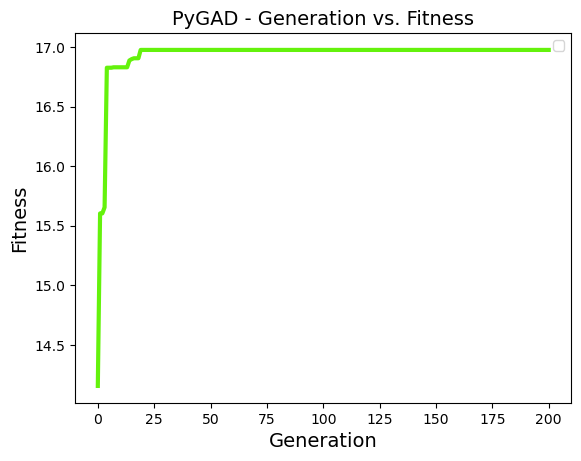

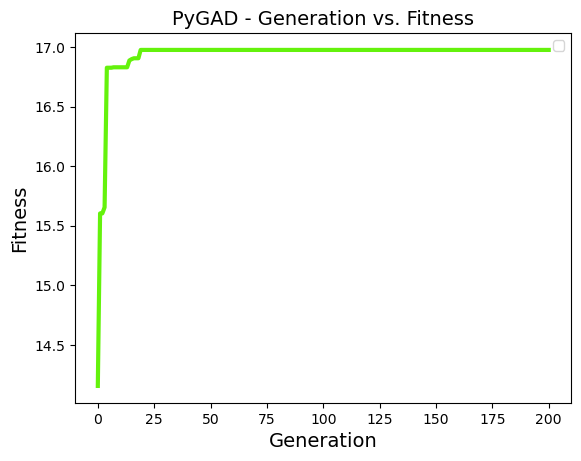

In [44]:
ga_instance.plot_fitness()

In [26]:
def generate_array(start, end, total_length):
    if end < start:
        raise ValueError("The second number must be greater than or equal to the first number.")
    
    if total_length <= 0:
        raise ValueError("The total_length must be a positive integer.")
    
    # Calculate the length of the portion with 0s
    zero_length = min(end - start, total_length)
    
    # Create the array with 1s initially
    result = [1] * total_length
    
    # Set the portion from start to end with 0s
    if zero_length > 0:
        result[start:start + zero_length] = [0] * zero_length
    
    return result

In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score

start_number = outlier_dims[0][0]
end_number = outlier_dims[0][1]
desired_length = 20

result_array = generate_array(start_number, end_number, desired_length)
result_array = np.array(result_array)

# Calculate precision, recall, and F1 score
precision = precision_score(1-result_array, solution)
recall = recall_score(1-result_array, solution)
f1 = f1_score(1-result_array, solution)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.8235294117647058
Recall: 1.0
F1 Score: 0.9032258064516129


In [28]:
result_array

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

In [30]:
for i, outlier_index in enumerate(outlier_inds):
    
    start_number = outlier_dims[i][0]
    end_number = outlier_dims[i][1]
    desired_length = 20

    result_array = generate_array(start_number, end_number, desired_length)
    true_labels = np.array(result_array)
    
    inlier_samples = dataset[:5, :]
    outlier_sample = dataset[outlier_index, :]
    
    ga_instance, solution = run_genetic_on_sample(inlier_samples, 
                                              outlier_sample, 
                                              rae, 
                                              num_dims=20, 
                                              num_generations = 40, 
                                              mutation_probability=0.1)
    
    precision = precision_score(1-true_labels, solution)
    recall = recall_score(1-true_labels, solution)
    f1 = f1_score(1-true_labels, solution)

    # Print the results
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

Precision: 0.9230769230769231
Recall: 0.8571428571428571
F1 Score: 0.888888888888889
Precision: 0.8235294117647058
Recall: 1.0
F1 Score: 0.9032258064516129
Precision: 0.7857142857142857
Recall: 0.7857142857142857
F1 Score: 0.7857142857142857
Precision: 0.8125
Recall: 0.9285714285714286
F1 Score: 0.8666666666666666
Precision: 0.8
Recall: 0.8571428571428571
F1 Score: 0.8275862068965518
Precision: 0.7647058823529411
Recall: 0.9285714285714286
F1 Score: 0.8387096774193549
Precision: 0.8571428571428571
Recall: 0.8571428571428571
F1 Score: 0.8571428571428571
Precision: 0.8666666666666667
Recall: 0.9285714285714286
F1 Score: 0.896551724137931
Precision: 0.8461538461538461
Recall: 0.7857142857142857
F1 Score: 0.8148148148148148
Precision: 0.7142857142857143
Recall: 0.7142857142857143
F1 Score: 0.7142857142857143
Precision: 0.6363636363636364
Recall: 0.7
F1 Score: 0.6666666666666666
Precision: 0.5454545454545454
Recall: 0.6
F1 Score: 0.5714285714285713
Precision: 0.4666666666666667
Recall: 0.7


KeyboardInterrupt: 

In [90]:
dataset[outlier_inds[0]]

array([ 1.72489976,  3.79988545,  4.88669797,  6.78653022,  4.47452789,
        5.58330981,  5.44677174,  9.89295494,  2.74854279,  4.0567402 ,
        7.45260837,  8.22710667,  3.45446456,  4.90834474,  0.408207  ,
        0.93612343,  0.87881386,  0.8002054 ,  0.62412487, -0.31169939])

In [91]:
outlier_dims[0]

(0, 14)